In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [49]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1C72k2HGGAtRQVkXIqh6xpyzd1jVXAvT6' -O Apple.csv

'wget' is not recognized as an internal or external command,
operable program or batch file.
'id' is not recognized as an internal or external command,
operable program or batch file.


### Preprocessing

In [50]:
data = pd.read_csv("Apple.csv")
df = data[data['region'] == 'UK']

In [51]:
df['type'].value_counts()

conventional    169
organic         169
Name: type, dtype: int64

In [52]:
df.drop(columns=["Unnamed: 0", "region"], inplace=True)
print(df)

            Date   Envi   Fuji  Gala          type
156   27/12/2015  30482   2972  5894  conventional
157   20/12/2015  25628   2546  7394  conventional
158   13/12/2015  27149   2986  6458  conventional
159    6/12/2015  35591  12527  4086  conventional
160   29/11/2015  24190   2790  6031  conventional
...          ...    ...    ...   ...           ...
6889    4/2/2018     77    590     0       organic
6890   28/1/2018     52    581     0       organic
6891   21/1/2018     41    577     0       organic
6892   14/1/2018     52    803     0       organic
6893    7/1/2018     43    949     0       organic

[338 rows x 5 columns]


c:\Users\phums\anaconda3\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [53]:
df = df.reset_index(drop=True)
df

,Date,Envi,Fuji,Gala,type
0,27/12/2015,30482,2972,5894,conventional
1,20/12/2015,25628,2546,7394,conventional
2,13/12/2015,27149,2986,6458,conventional
3,6/12/2015,35591,12527,4086,conventional
4,29/11/2015,24190,2790,6031,conventional
...,...,...,...,...,...
333,4/2/2018,77,590,0,organic
334,28/1/2018,52,581,0,organic
335,21/1/2018,41,577,0,organic
336,14/1/2018,52,803,0,organic


In [54]:
# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

In [55]:
conventional_envi = df[df['type'] == 'conventional'][['Date', 'Envi']]
organic_envi = df[df['type'] == 'organic'][['Date', 'Envi']]
conventional_envi['y'] = df['Envi'].shift(-1)
organic_envi['y'] = df['Envi'].shift(-1)

conventional_fuji = df[df['type'] == 'conventional'][['Date', 'Fuji']]
organic_fuji = df[df['type'] == 'organic'][['Date', 'Fuji']]
conventional_fuji['y'] = df['Fuji'].shift(-1)
organic_fuji['y'] = df['Fuji'].shift(-1)

conventional_gala = df[df['type'] == 'conventional'][['Date', 'Gala']]
organic_gala = df[df['type'] == 'organic'][['Date', 'Gala']]
conventional_gala['y'] = df['Gala'].shift(-1)
organic_gala['y'] = df['Gala'].shift(-1)

### Lasso Algorithm


In [56]:
from sklearn import linear_model
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [57]:
def plot_graph(title, species, train, test, X_test, model):
    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.plot(train['Date'], train[species], label='Train')
    plt.plot(test['Date'], test[species], label='Test')
    plt.plot(test['Date'], model.predict(X_test), label='Lasso Predictions')
    plt.xlabel('Date')
    plt.ylabel('Number of Apples')
    plt.legend()
    plt.show()

In [58]:
conventional_envi_for_lasso = conventional_envi.copy()
conventional_fuji_for_lasso = conventional_fuji.copy()
conventional_gala_for_lasso = conventional_gala.copy()
organic_envi_for_lasso = organic_envi.copy()
organic_fuji_for_lasso = organic_fuji.copy()
organic_gala_for_lasso = organic_gala.copy()

#### Conventional

##### Envi

In [59]:
conventional_envi_for_lasso['Date'] = pd.to_datetime(conventional_envi_for_lasso['Date'])
conventional_envi_for_lasso = conventional_envi_for_lasso.sort_values(by='Date')
conventional_envi_for_lasso['y'] = conventional_envi_for_lasso['Envi'].shift(-1)

conventional_envi_for_lasso = conventional_envi_for_lasso.drop(conventional_envi_for_lasso.tail(1).index)

test_cutoff_date = conventional_envi_for_lasso['Date'].max() - pd.DateOffset(years=1)

train = conventional_envi_for_lasso[conventional_envi_for_lasso['Date'] < test_cutoff_date]
test = conventional_envi_for_lasso[conventional_envi_for_lasso['Date'] >= test_cutoff_date]
test.drop(test.tail(1).index).head(5)

test = test.reset_index(drop=True)

X_train = train['Envi'].values.reshape(-1,1)
y_train = train['y'].values.reshape(-1,1)
X_test = test['Envi'].values.reshape(-1,1)
y_test = test['y'].values.reshape(-1,1)

In [60]:
lasso = linear_model.Lasso()

parameters = {'alpha': [0.001, 0.01, 0.1]}
lasso_model = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(), param_grid={'alpha': [0.001, 0.01, 0.1]},
             scoring='neg_mean_squared_error')

In [61]:
print("Best parameters:", lasso_model.best_params_)
print("Best score:", lasso_model.best_score_)

Best parameters: {'alpha': 0.001}
Best score: -90549588.73898384


In [62]:
model = Lasso(alpha=lasso_model.best_params_.get('alpha'))

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [63]:
#Mean Absolute Error
mae = mean_absolute_error(X_test, y_pred)
print("Mean absolute error:", mae)
#The mean squared error
mse =mean_squared_error(X_test, y_pred)
print("Mean squared error: ",mse)
#R2-score
r2_value = r2_score(X_test, y_pred)
print('r2-score: ', r2_value)

Mean absolute error: 3046.6181412478354
Mean squared error:  18961984.313150812
r2-score:  0.7241176607405259


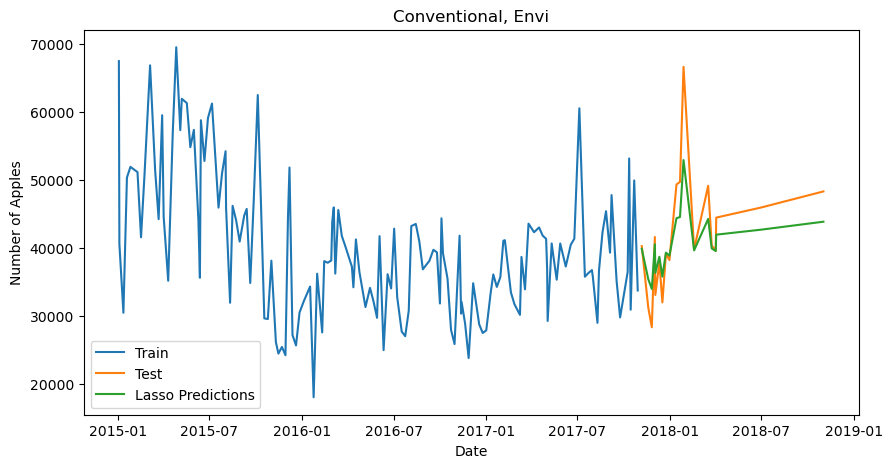

In [64]:
plot_graph('Conventional, Envi', 'Envi', train, test, X_test, lasso_model)

##### Fuji

In [65]:
conventional_fuji_for_lasso['Date'] = pd.to_datetime(conventional_fuji_for_lasso['Date'])
conventional_fuji_for_lasso = conventional_fuji_for_lasso.sort_values(by='Date')
conventional_fuji_for_lasso['y'] = conventional_fuji_for_lasso['Fuji'].shift(-1)

conventional_fuji_for_lasso = conventional_fuji_for_lasso.drop(conventional_fuji_for_lasso.tail(1).index)

test_cutoff_date = conventional_fuji_for_lasso['Date'].max() - pd.DateOffset(years=1)

train = conventional_fuji_for_lasso[conventional_fuji_for_lasso['Date'] < test_cutoff_date]
test = conventional_fuji_for_lasso[conventional_fuji_for_lasso['Date'] >= test_cutoff_date]
test.drop(test.tail(1).index).head(5)

test = test.reset_index(drop=True)

X_train = train['Fuji'].values.reshape(-1,1)
y_train = train['y'].values.reshape(-1,1)
X_test = test['Fuji'].values.reshape(-1,1)
y_test = test['y'].values.reshape(-1,1)

In [66]:
lasso = linear_model.Lasso()

parameters = {'alpha': [0.001, 0.01, 0.1]}
lasso_model = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(), param_grid={'alpha': [0.001, 0.01, 0.1]},
             scoring='neg_mean_squared_error')

In [67]:
print("Best parameters:", lasso_model.best_params_)
print("Best score:", lasso_model.best_score_)

Best parameters: {'alpha': 0.001}
Best score: -22590751.98896325


In [68]:
model = Lasso(alpha=lasso_model.best_params_.get('alpha'))

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [69]:
#Mean Absolute Error
mae = mean_absolute_error(X_test, y_pred)
print("Mean absolute error:", mae)
#The mean squared error
mse =mean_squared_error(X_test, y_pred)
print("Mean squared error: ",mse)
#R2-score
r2_value = r2_score(X_test, y_pred)
print('r2-score: ', r2_value)

Mean absolute error: 2037.3202555891646
Mean squared error:  4568116.837106918
r2-score:  0.2850921976414754


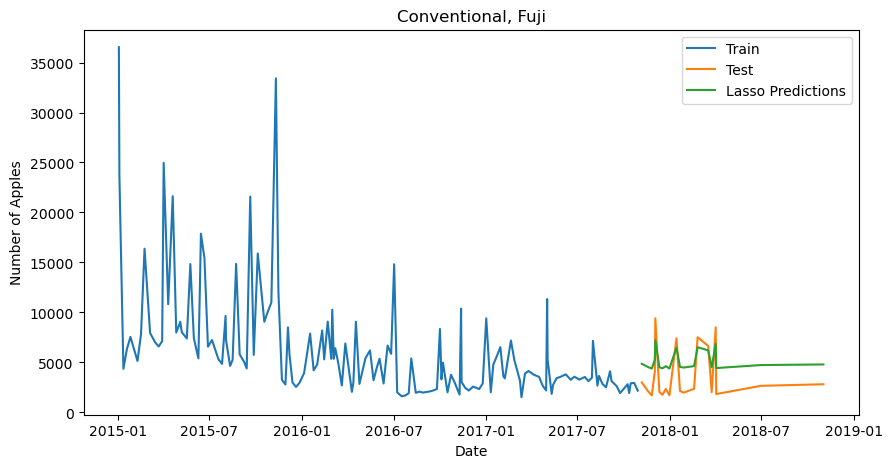

In [70]:
plot_graph('Conventional, Fuji', 'Fuji', train, test, X_test, lasso_model)

##### Gala

In [71]:
conventional_gala_for_lasso['Date'] = pd.to_datetime(conventional_gala_for_lasso['Date'])
conventional_gala_for_lasso = conventional_gala_for_lasso.sort_values(by='Date')
conventional_gala_for_lasso['y'] = conventional_gala_for_lasso['Gala'].shift(-1)

conventional_gala_for_lasso = conventional_gala_for_lasso.drop(conventional_gala_for_lasso.tail(1).index)

test_cutoff_date = conventional_gala_for_lasso['Date'].max() - pd.DateOffset(years=1)

train = conventional_gala_for_lasso[conventional_gala_for_lasso['Date'] < test_cutoff_date]
test = conventional_gala_for_lasso[conventional_gala_for_lasso['Date'] >= test_cutoff_date]
test.drop(test.tail(1).index).head(5)

test = test.reset_index(drop=True)

X_train = train['Gala'].values.reshape(-1,1)
y_train = train['y'].values.reshape(-1,1)
X_test = test['Gala'].values.reshape(-1,1)
y_test = test['y'].values.reshape(-1,1)

In [72]:
lasso = linear_model.Lasso()

parameters = {'alpha': [0.001, 0.01, 0.1]}
lasso_model = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(), param_grid={'alpha': [0.001, 0.01, 0.1]},
             scoring='neg_mean_squared_error')

In [73]:
print("Best parameters:", lasso_model.best_params_)
print("Best score:", lasso_model.best_score_)

Best parameters: {'alpha': 0.001}
Best score: -11112720.648376465


In [74]:
model = Lasso(alpha=lasso_model.best_params_.get('alpha'))

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [75]:
#Mean Absolute Error
mae = mean_absolute_error(X_test, y_pred)
print("Mean absolute error:", mae)
#The mean squared error
mse =mean_squared_error(X_test, y_pred)
print("Mean squared error: ",mse)
#R2-score
r2_value = r2_score(X_test, y_pred)
print('r2-score: ', r2_value)

Mean absolute error: 1959.7118174735533
Mean squared error:  9567201.212245129
r2-score:  0.32239211718072736


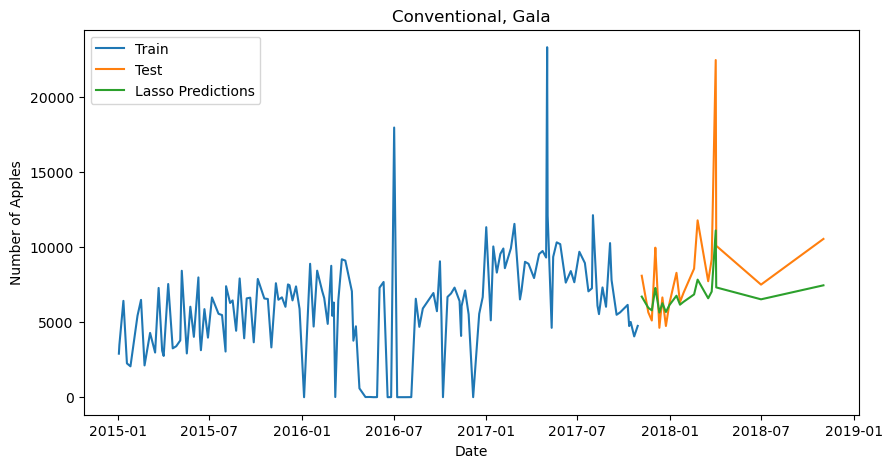

In [76]:
plot_graph('Conventional, Gala', 'Gala', train, test, X_test, lasso_model)

#### Organic

##### Envi

In [77]:
organic_envi_for_lasso['Date'] = pd.to_datetime(organic_envi_for_lasso['Date'])
organic_envi_for_lasso = organic_envi_for_lasso.sort_values(by='Date')
organic_envi_for_lasso['y'] = organic_envi_for_lasso['Envi'].shift(-1)

organic_envi_for_lasso = organic_envi_for_lasso.drop(organic_envi_for_lasso.tail(1).index)

test_cutoff_date = organic_envi_for_lasso['Date'].max() - pd.DateOffset(years=1)

train = organic_envi_for_lasso[organic_envi_for_lasso['Date'] < test_cutoff_date]
test = organic_envi_for_lasso[organic_envi_for_lasso['Date'] >= test_cutoff_date]
test.drop(test.tail(1).index).head(5)

test = test.reset_index(drop=True)

X_train = train['Envi'].values.reshape(-1,1)
y_train = train['y'].values.reshape(-1,1)
X_test = test['Envi'].values.reshape(-1,1)
y_test = test['y'].values.reshape(-1,1)

In [78]:
lasso = linear_model.Lasso()

parameters = {'alpha': [0.001, 0.01, 0.1]}
lasso_model = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(), param_grid={'alpha': [0.001, 0.01, 0.1]},
             scoring='neg_mean_squared_error')

In [79]:
print("Best parameters:", lasso_model.best_params_)
print("Best score:", lasso_model.best_score_)

Best parameters: {'alpha': 0.001}
Best score: -510.9275193769783


In [80]:
model = Lasso(alpha=lasso_model.best_params_.get('alpha'))

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [81]:
#Mean Absolute Error
mae = mean_absolute_error(X_test, y_pred)
print("Mean absolute error:", mae)
#The mean squared error
mse =mean_squared_error(X_test, y_pred)
print("Mean squared error: ",mse)
#R2-score
r2_value = r2_score(X_test, y_pred)
print('r2-score: ', r2_value)

Mean absolute error: 17.998601487560826
Mean squared error:  444.4622290601521
r2-score:  0.24673483226324644


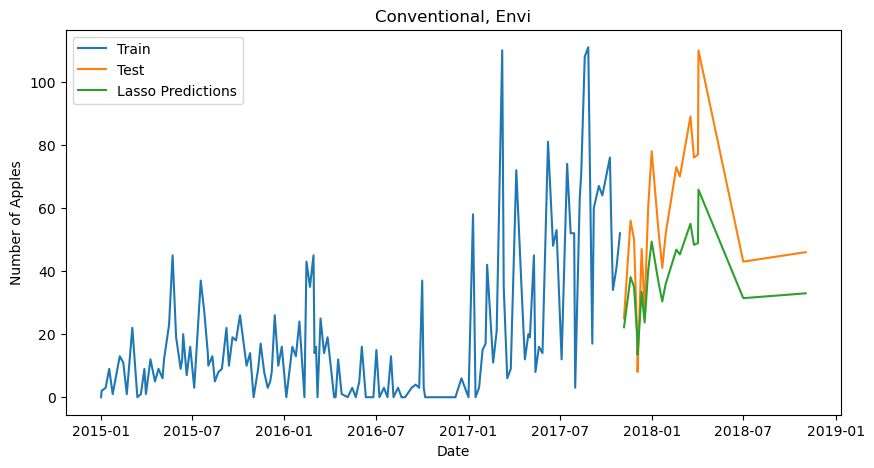

In [82]:
plot_graph('Conventional, Envi', 'Envi', train, test, X_test, lasso_model)

##### Fuji

In [83]:
organic_fuji_for_lasso['Date'] = pd.to_datetime(organic_fuji_for_lasso['Date'])
organic_fuji_for_lasso = organic_fuji_for_lasso.sort_values(by='Date')
organic_fuji_for_lasso['y'] = organic_fuji_for_lasso['Fuji'].shift(-1)

organic_fuji_for_lasso = organic_fuji_for_lasso.drop(organic_fuji_for_lasso.tail(1).index)

test_cutoff_date = organic_fuji_for_lasso['Date'].max() - pd.DateOffset(years=1)

train = organic_fuji_for_lasso[organic_fuji_for_lasso['Date'] < test_cutoff_date]
test = organic_fuji_for_lasso[organic_fuji_for_lasso['Date'] >= test_cutoff_date]
test.drop(test.tail(1).index).head(5)

test = test.reset_index(drop=True)

X_train = train['Fuji'].values.reshape(-1,1)
y_train = train['y'].values.reshape(-1,1)
X_test = test['Fuji'].values.reshape(-1,1)
y_test = test['y'].values.reshape(-1,1)

In [84]:
lasso = linear_model.Lasso()

parameters = {'alpha': [0.001, 0.01, 0.1]}
lasso_model = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(), param_grid={'alpha': [0.001, 0.01, 0.1]},
             scoring='neg_mean_squared_error')

In [85]:
print("Best parameters:", lasso_model.best_params_)
print("Best score:", lasso_model.best_score_)

Best parameters: {'alpha': 0.001}
Best score: -561484.3860966463


In [86]:
model = Lasso(alpha=lasso_model.best_params_.get('alpha'))

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [87]:
#Mean Absolute Error
mae = mean_absolute_error(X_test, y_pred)
print("Mean absolute error:", mae)
#The mean squared error
mse =mean_squared_error(X_test, y_pred)
print("Mean squared error: ",mse)
#R2-score
r2_value = r2_score(X_test, y_pred)
print('r2-score: ', r2_value)

Mean absolute error: 194.4853366362758
Mean squared error:  48421.821310783955
r2-score:  -0.7989368508786465


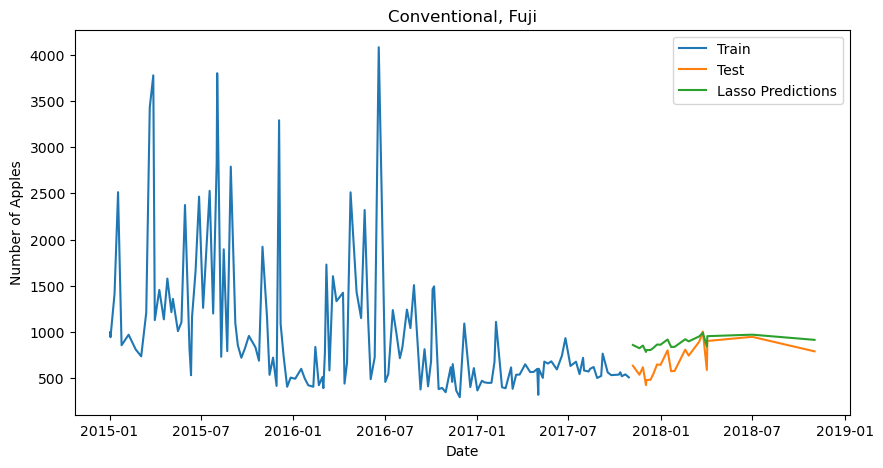

In [88]:
plot_graph('Conventional, Fuji', 'Fuji', train, test, X_test, lasso_model)

##### Gala

In [89]:
organic_gala_for_lasso['Date'] = pd.to_datetime(organic_gala_for_lasso['Date'])
organic_gala_for_lasso = organic_gala_for_lasso.sort_values(by='Date')
organic_gala_for_lasso['y'] = organic_gala_for_lasso['Gala'].shift(-1)

organic_gala_for_lasso = organic_gala_for_lasso.drop(organic_gala_for_lasso.tail(1).index)

test_cutoff_date = organic_gala_for_lasso['Date'].max() - pd.DateOffset(years=1)

train = organic_gala_for_lasso[organic_gala_for_lasso['Date'] < test_cutoff_date]
test = organic_gala_for_lasso[organic_gala_for_lasso['Date'] >= test_cutoff_date]
test.drop(test.tail(1).index).head(5)

test = test.reset_index(drop=True)

X_train = train['Gala'].values.reshape(-1,1)
y_train = train['y'].values.reshape(-1,1)
X_test = test['Gala'].values.reshape(-1,1)
y_test = test['y'].values.reshape(-1,1)

In [90]:
lasso = linear_model.Lasso()

parameters = {'alpha': [0.001, 0.01, 0.1]}
lasso_model = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Lasso(), param_grid={'alpha': [0.001, 0.01, 0.1]},
             scoring='neg_mean_squared_error')

In [91]:
print("Best parameters:", lasso_model.best_params_)
print("Best score:", lasso_model.best_score_)

Best parameters: {'alpha': 0.1}
Best score: -0.3343115883323774


In [92]:
model = Lasso(alpha=lasso_model.best_params_.get('alpha'))

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [93]:
#Mean Absolute Error
mae = mean_absolute_error(X_test, y_pred)
print("Mean absolute error:", mae)
#The mean squared error
mse =mean_squared_error(X_test, y_pred)
print("Mean squared error: ",mse)
#R2-score
r2_value = r2_score(X_test, y_pred)
print('r2-score: ', r2_value)

Mean absolute error: 0.09459459459459459
Mean squared error:  0.008948137326515703
r2-score:  0.0


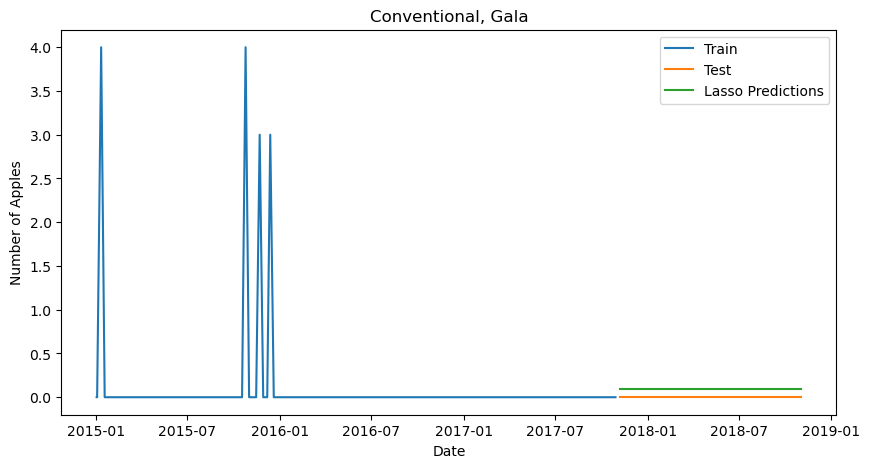

In [94]:
plot_graph('Conventional, Gala', 'Gala', train, test, X_test, lasso_model)